In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import math

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 

In [3]:
cdc_diabetes_health_indicators.variables

name     role     type      demographic  \
0                     ID       ID  Integer             None   
1        Diabetes_binary   Target   Binary             None   
2                 HighBP  Feature   Binary             None   
3               HighChol  Feature   Binary             None   
4              CholCheck  Feature   Binary             None   
5                    BMI  Feature  Integer             None   
6                 Smoker  Feature   Binary             None   
7                 Stroke  Feature   Binary             None   
8   HeartDiseaseorAttack  Feature   Binary             None   
9           PhysActivity  Feature   Binary             None   
10                Fruits  Feature   Binary             None   
11               Veggies  Feature   Binary             None   
12     HvyAlcoholConsump  Feature   Binary             None   
13         AnyHealthcare  Feature   Binary             None   
14           NoDocbcCost  Feature   Binary             None   
15               GenHlth  Feature  Integer             None   
16              MentHlth  Feature  Integer             None   
17              PhysHlth  Feature  Integer             None   
18              DiffWalk  Feature   Binary             None   
19                   Sex  Feature   Binary              Sex   
20                   Age  Feature  Integer              Age   
21             Education  Feature  Integer  Education Level   
22                Income  Feature  Integer           Income   

                                          description units missing_values  
0                                          Patient ID  None             no  
1         0 = no diabetes 1 = prediabetes or diabetes  None             no  
2                          0 = no high BP 1 = high BP  None             no  
3        0 = no high cholesterol 1 = high cholesterol  None             no  
4   0 = no cholesterol check in 5 years 1 = yes ch...  None             no  
5                                     Body Mass Index  None             no  
6   Have you smoked at least 100 cigarettes in you...  None             no  
7        (Ever told) you had a stroke. 0 = no 1 = yes  None             no  
8   coronary heart disease (CHD) or myocardial inf...  None             no  
9   physical activity in past 30 days - not includ...  None             no  
10  Consume Fruit 1 or more times per day 0 = no 1...  None             no  
11  Consume Vegetables 1 or more times per day 0 =...  None             no  
12  Heavy drinkers (adult men having more than 14 ...  None             no  
13  Have any kind of health care coverage, includi...  None             no  
14  Was there a time in the past 12 months when yo...  None             no  
15  Would you say that in general your health is: ...  None             no  
16  Now thinking about your mental health, which i...  None             no  
17  Now thinking about your physical health, which...  None             no  
18  Do you have serious difficulty walking or clim...  None             no  
19                                0 = female 1 = male  None             no  
20  13-level age category (_AGEG5YR see codebook) ...  None             no  
21  Education level (EDUCA see codebook) scale 1-6...  None             no  
22  Income scale (INCOME2 see codebook) scale 1-8 ...  None             no

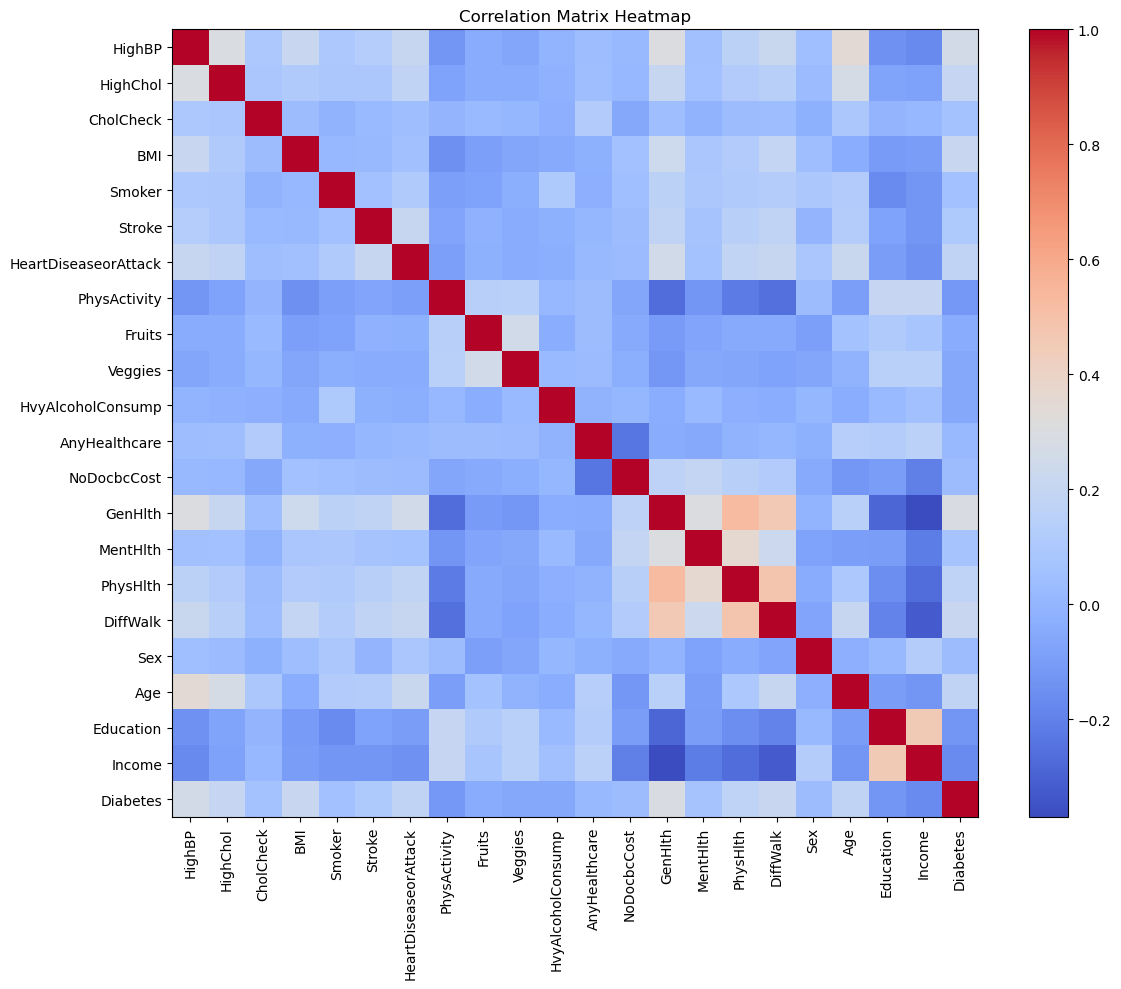

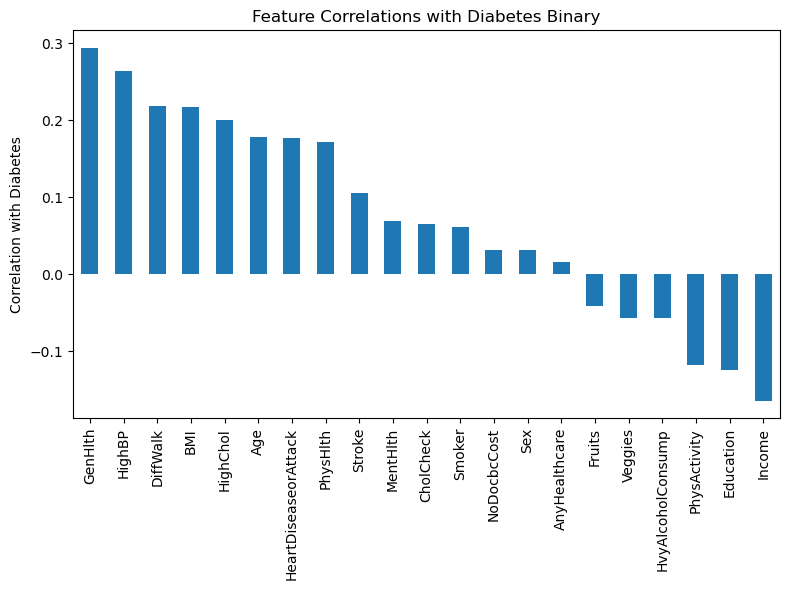

In [4]:
df = X.copy()
df['Diabetes'] = y

corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

target_corr = corr_matrix['Diabetes'].drop('Diabetes').sort_values(ascending=False)

plt.figure(figsize=(8, 6))
target_corr.plot(kind='bar')
plt.ylabel('Correlation with Diabetes')
plt.title('Feature Correlations with Diabetes Binary')
plt.tight_layout()
plt.show()

In [6]:
df.groupby('Diabetes')['HighBP'].count()

Diabetes
0    218334
1     35346
Name: HighBP, dtype: int64

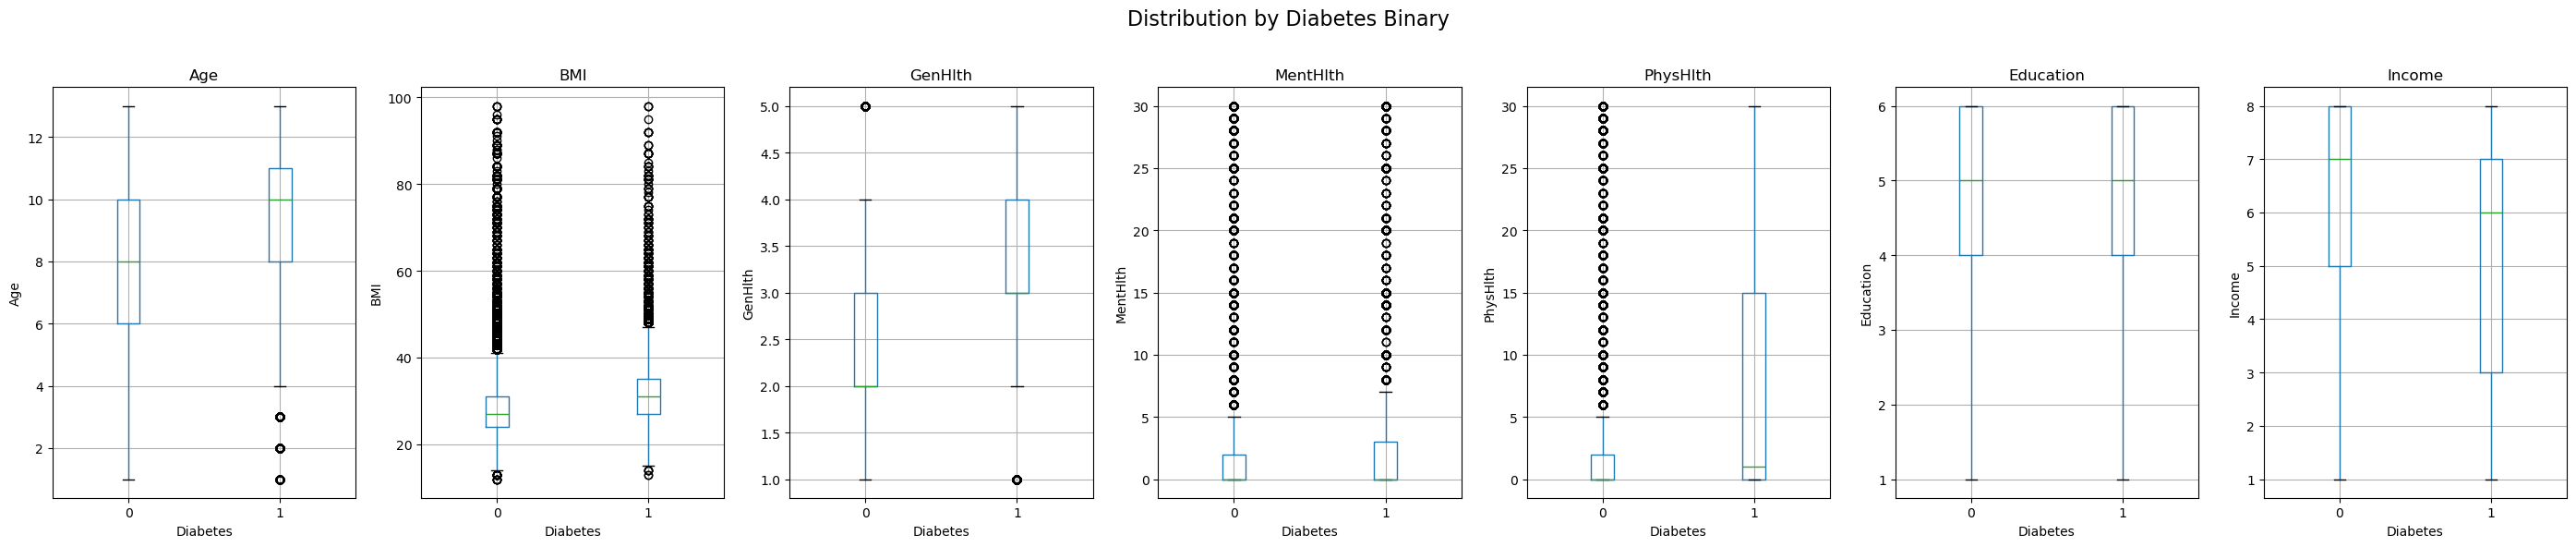

In [7]:
features_to_plot = ['Age', 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Education', 'Income']

fig, axes = plt.subplots(1, len(features_to_plot), figsize=(28, 6))

for ax, feature in zip(axes, features_to_plot):
    df.boxplot(column=feature, by='Diabetes', ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('Diabetes')
    ax.set_ylabel(feature)

fig.suptitle('Distribution by Diabetes Binary', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [41]:
cdc_diabetes_health_indicators.variables

name     role     type      demographic  \
0                     ID       ID  Integer             None   
1        Diabetes_binary   Target   Binary             None   
2                 HighBP  Feature   Binary             None   
3               HighChol  Feature   Binary             None   
4              CholCheck  Feature   Binary             None   
5                    BMI  Feature  Integer             None   
6                 Smoker  Feature   Binary             None   
7                 Stroke  Feature   Binary             None   
8   HeartDiseaseorAttack  Feature   Binary             None   
9           PhysActivity  Feature   Binary             None   
10                Fruits  Feature   Binary             None   
11               Veggies  Feature   Binary             None   
12     HvyAlcoholConsump  Feature   Binary             None   
13         AnyHealthcare  Feature   Binary             None   
14           NoDocbcCost  Feature   Binary             None   
15               GenHlth  Feature  Integer             None   
16              MentHlth  Feature  Integer             None   
17              PhysHlth  Feature  Integer             None   
18              DiffWalk  Feature   Binary             None   
19                   Sex  Feature   Binary              Sex   
20                   Age  Feature  Integer              Age   
21             Education  Feature  Integer  Education Level   
22                Income  Feature  Integer           Income   

                                          description units missing_values  
0                                          Patient ID  None             no  
1         0 = no diabetes 1 = prediabetes or diabetes  None             no  
2                          0 = no high BP 1 = high BP  None             no  
3        0 = no high cholesterol 1 = high cholesterol  None             no  
4   0 = no cholesterol check in 5 years 1 = yes ch...  None             no  
5                                     Body Mass Index  None             no  
6   Have you smoked at least 100 cigarettes in you...  None             no  
7        (Ever told) you had a stroke. 0 = no 1 = yes  None             no  
8   coronary heart disease (CHD) or myocardial inf...  None             no  
9   physical activity in past 30 days - not includ...  None             no  
10  Consume Fruit 1 or more times per day 0 = no 1...  None             no  
11  Consume Vegetables 1 or more times per day 0 =...  None             no  
12  Heavy drinkers (adult men having more than 14 ...  None             no  
13  Have any kind of health care coverage, includi...  None             no  
14  Was there a time in the past 12 months when yo...  None             no  
15  Would you say that in general your health is: ...  None             no  
16  Now thinking about your mental health, which i...  None             no  
17  Now thinking about your physical health, which...  None             no  
18  Do you have serious difficulty walking or clim...  None             no  
19                                0 = female 1 = male  None             no  
20  13-level age category (_AGEG5YR see codebook) ...  None             no  
21  Education level (EDUCA see codebook) scale 1-6...  None             no  
22  Income scale (INCOME2 see codebook) scale 1-8 ...  None             no

Identified binary columns: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']


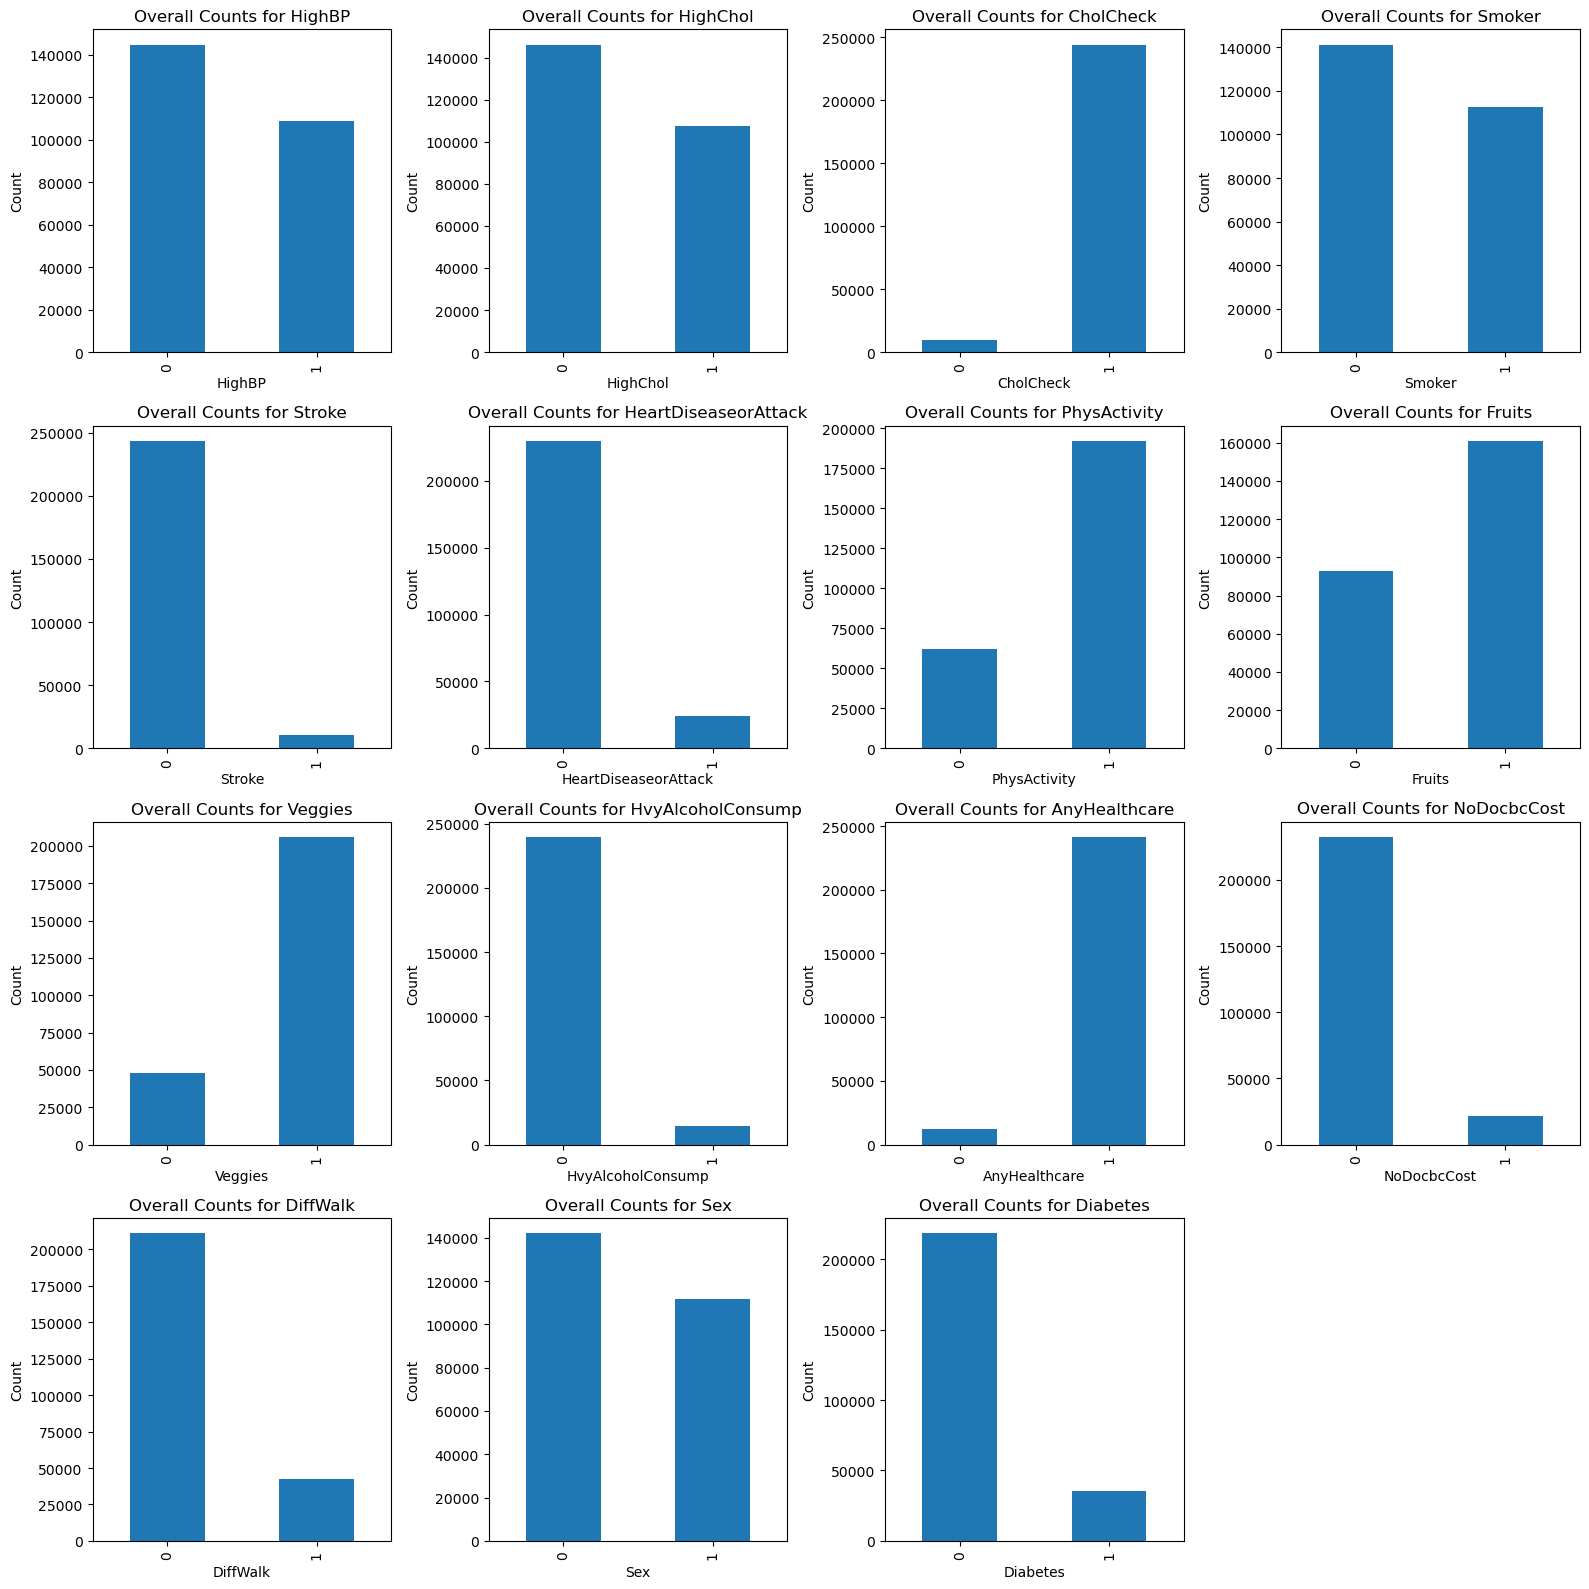

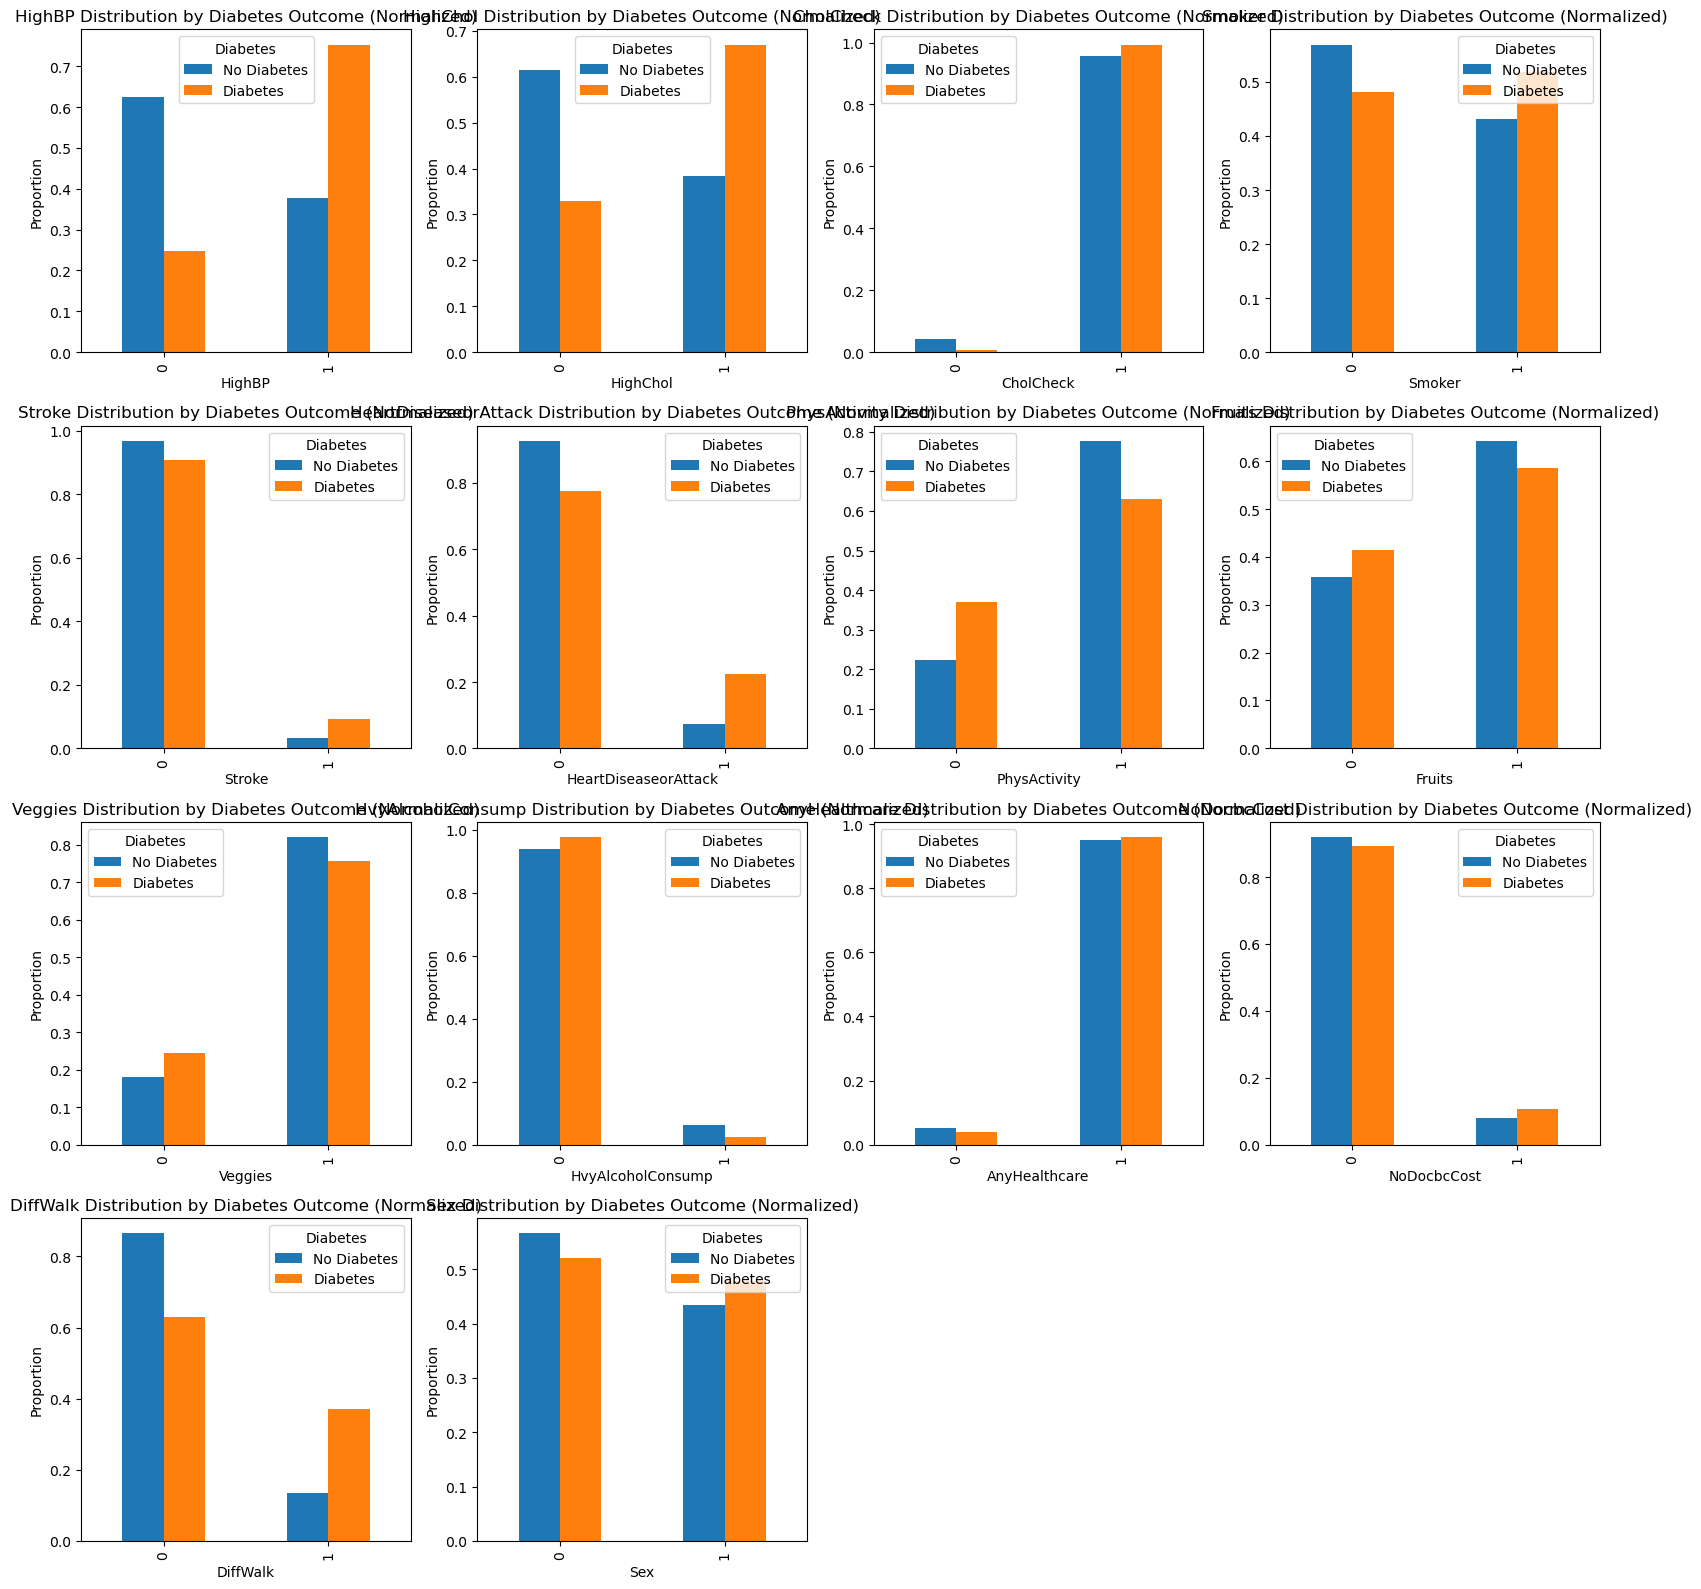

In [10]:
binary_cols = []
for col in df.columns:
    if col != 'Diabetes':
        unique_vals = df[col].dropna().unique()
        if set(unique_vals).issubset({0, 1}):
            binary_cols.append(col)

print("Identified binary columns:", binary_cols)

# --- Figure 1: Overall Counts for Each Binary Column (including 'Diabetes') ---
# Create a list that includes all binary columns plus 'Diabetes'
count_cols = binary_cols.copy()
if 'Diabetes' not in count_cols:
    count_cols.append('Diabetes')

# Set grid dimensions (e.g., 4 columns per row)
n_plots = len(count_cols)
n_cols = 4
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Flatten in case we have multiple rows

# Plot overall counts for each column
for ax, col in zip(axes, count_cols):
    counts = df[col].value_counts().sort_index()
    counts.plot(kind='bar', ax=ax)
    ax.set_title(f'Overall Counts for {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

# Turn off any unused axes
for ax in axes[len(count_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


# --- Figure 2: Normalized Distribution by Diabetes Outcome for Binary Columns ---
# (Excluding Diabetes from the list because it is used as the reference)
n_plots = len(binary_cols)
n_cols = 4
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Plot normalized distribution for each binary column
for ax, col in zip(axes, binary_cols):
    crosstab_norm = pd.crosstab(df[col], df['Diabetes'], normalize='columns')
    crosstab_norm.plot(kind='bar', ax=ax)
    ax.set_title(f'{col} Distribution by Diabetes Outcome (Normalized)')
    ax.set_xlabel(col)
    ax.set_ylabel('Proportion')
    ax.legend(title='Diabetes', labels=['No Diabetes', 'Diabetes'])

# Turn off any unused axes
for ax in axes[len(binary_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
X_new = X.copy()

risk_cols = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'DiffWalk']
X_new['CardioRiskScore'] = X_new[risk_cols].sum(axis=1)

X_new['WellnessScore'] = X_new['GenHlth'] - ((X_new['MentHlth'] + X_new['PhysHlth']) / 30)

X_new['SES'] = X_new['Education'] + X_new['Income']

X_new['LifestyleScore'] = X_new[['PhysActivity', 'Fruits', 'Veggies']].sum(axis=1) - X_new[['Smoker', 'HvyAlcoholConsump']].sum(axis=1)

X_new['Age_BMI_Interaction'] = X_new['Age'] * X_new['BMI']

X_new['MentalToPhysicalRatio'] = X_new.apply(lambda row: row['MentHlth'] / row['PhysHlth'] if row['PhysHlth'] != 0 else 0, axis=1)

X_new['HealthcareAccess'] = X_new['AnyHealthcare'] - X_new['NoDocbcCost']

In [12]:
X_new.dtypes

HighBP                     int64
HighChol                   int64
CholCheck                  int64
BMI                        int64
Smoker                     int64
Stroke                     int64
HeartDiseaseorAttack       int64
PhysActivity               int64
Fruits                     int64
Veggies                    int64
HvyAlcoholConsump          int64
AnyHealthcare              int64
NoDocbcCost                int64
GenHlth                    int64
MentHlth                   int64
PhysHlth                   int64
DiffWalk                   int64
Sex                        int64
Age                        int64
Education                  int64
Income                     int64
CardioRiskScore            int64
WellnessScore            float64
SES                        int64
LifestyleScore             int64
Age_BMI_Interaction        int64
MentalToPhysicalRatio    float64
HealthcareAccess           int64
dtype: object

In [13]:
def cluster_training_data(features, outcome, cluster_list, outcome_col='Diabetes', test_size=0.2, random_state=42):
    """
    Splits the full dataset into training and testing sets.
    Uses only the training set to compute clustering centroids.
    
    For each n_clusters in cluster_list:
      - Builds a pipeline with a preprocessor (scaling numerical and one-hot encoding categorical features)
        and KMeans clustering on the training data.
      - Attaches the resulting cluster labels to a new training dataframe.
      - Saves the clustering pipeline and centroids.
      - Plots a PCA visualization for the training set in a grid of subplots.
      
    Parameters:
      features     : DataFrame containing only the features (e.g., X_new).
      outcome      : Series containing the outcome labels (e.g., y).
      cluster_list : List of integers specifying the number of clusters to try (e.g., [2,3,4,5,6,7,8]).
      outcome_col  : Name of the outcome column to add (default 'Diabetes').
      test_size    : Fraction of data to hold out as testing (default 0.2).
      random_state : Random state for reproducibility.
      
    Returns:
      A dictionary with two keys:
        'clusters'  : A dictionary mapping each n_clusters value to a dict with:
                          - 'train_df': Training data with cluster labels.
                          - 'pipeline': The clustering pipeline (trained on training data).
                          - 'centroids': The KMeans centroids.
        'test_data' : The held-out testing DataFrame (with outcome, but without cluster labels).
    """
    # Prepare the full data
    data = features.copy()
    data[outcome_col] = outcome
    
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state)
    X_train = train_data.drop(columns=[outcome_col])
    
    # Determine numerical and categorical features
    num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
        ]
    )
    
    cluster_results = {}
    
    # Set up the grid for PCA plots: 2 columns per row is used here
    n_plots = len(cluster_list)
    n_cols = 2
    n_rows = math.ceil(n_plots / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 7 * n_rows))
    # Ensure axes is a flat array even if there is only one row or one plot
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Loop through each clustering configuration and plot its PCA result
    for idx, n in enumerate(cluster_list):
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('kmeans', KMeans(n_clusters=n, random_state=42))
        ])
        
        pipeline.fit(X_train)
        cluster_labels = pipeline.predict(X_train)
        
        # Save the clustering result
        train_df_with_clusters = train_data.copy()
        train_df_with_clusters['cluster'] = cluster_labels
        centroids = pipeline.named_steps['kmeans'].cluster_centers_
        cluster_results[n] = {
            'train_df': train_df_with_clusters,
            'pipeline': pipeline,
            'centroids': centroids
        }
        
        # Prepare data for PCA: transform and then reduce to 2 dimensions
        X_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
        if hasattr(X_transformed, "toarray"):
            X_transformed = X_transformed.toarray()
            
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_transformed)
        
        # Plot on the corresponding subplot axis
        ax = axes[idx]
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_title(f'PCA for n_clusters = {n}')
        legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
        ax.add_artist(legend1)
    
    # Hide any unused subplots if the grid has extra cells
    for ax in axes[len(cluster_list):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {'clusters': cluster_results, 'test_data': test_data}


### 2, 3, 4, and 5 show the most promies in terms of being useful labels. 6, 7, and 8 clusters have to much overlap and probably wont be useful. 

# SVM with all original features

In [14]:
y_one = y.iloc[:,:1].to_numpy().T[0]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_one, test_size=0.2, random_state=42)

# SVM with L2 penalty
pipeline_l2 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(penalty='l2', dual=True, random_state=42, max_iter=10000, class_weight='balanced'))
])
pipeline_l2.fit(X_train, y_train)
pred_l2 = pipeline_l2.predict(X_test)
print("Classification Report for SVM with L2 Penalty:")
print(classification_report(y_test, pred_l2))

# SVM with L1 penalty
pipeline_l1 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(penalty='l1', dual=False, random_state=42, max_iter=10000, class_weight='balanced'))
])
pipeline_l1.fit(X_train, y_train)
pred_l1 = pipeline_l1.predict(X_test)
print("Classification Report for SVM with L1 Penalty:")
print(classification_report(y_test, pred_l1))

c:\Users\angel\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report for SVM with L2 Penalty:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     43739
           1       0.31      0.78      0.44      6997

    accuracy                           0.73     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.86      0.73      0.77     50736

Classification Report for SVM with L1 Penalty:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     43739
           1       0.31      0.78      0.44      6997

    accuracy                           0.73     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.86      0.73      0.77     50736



# SVM with cluster labels as feature, 3 clusters

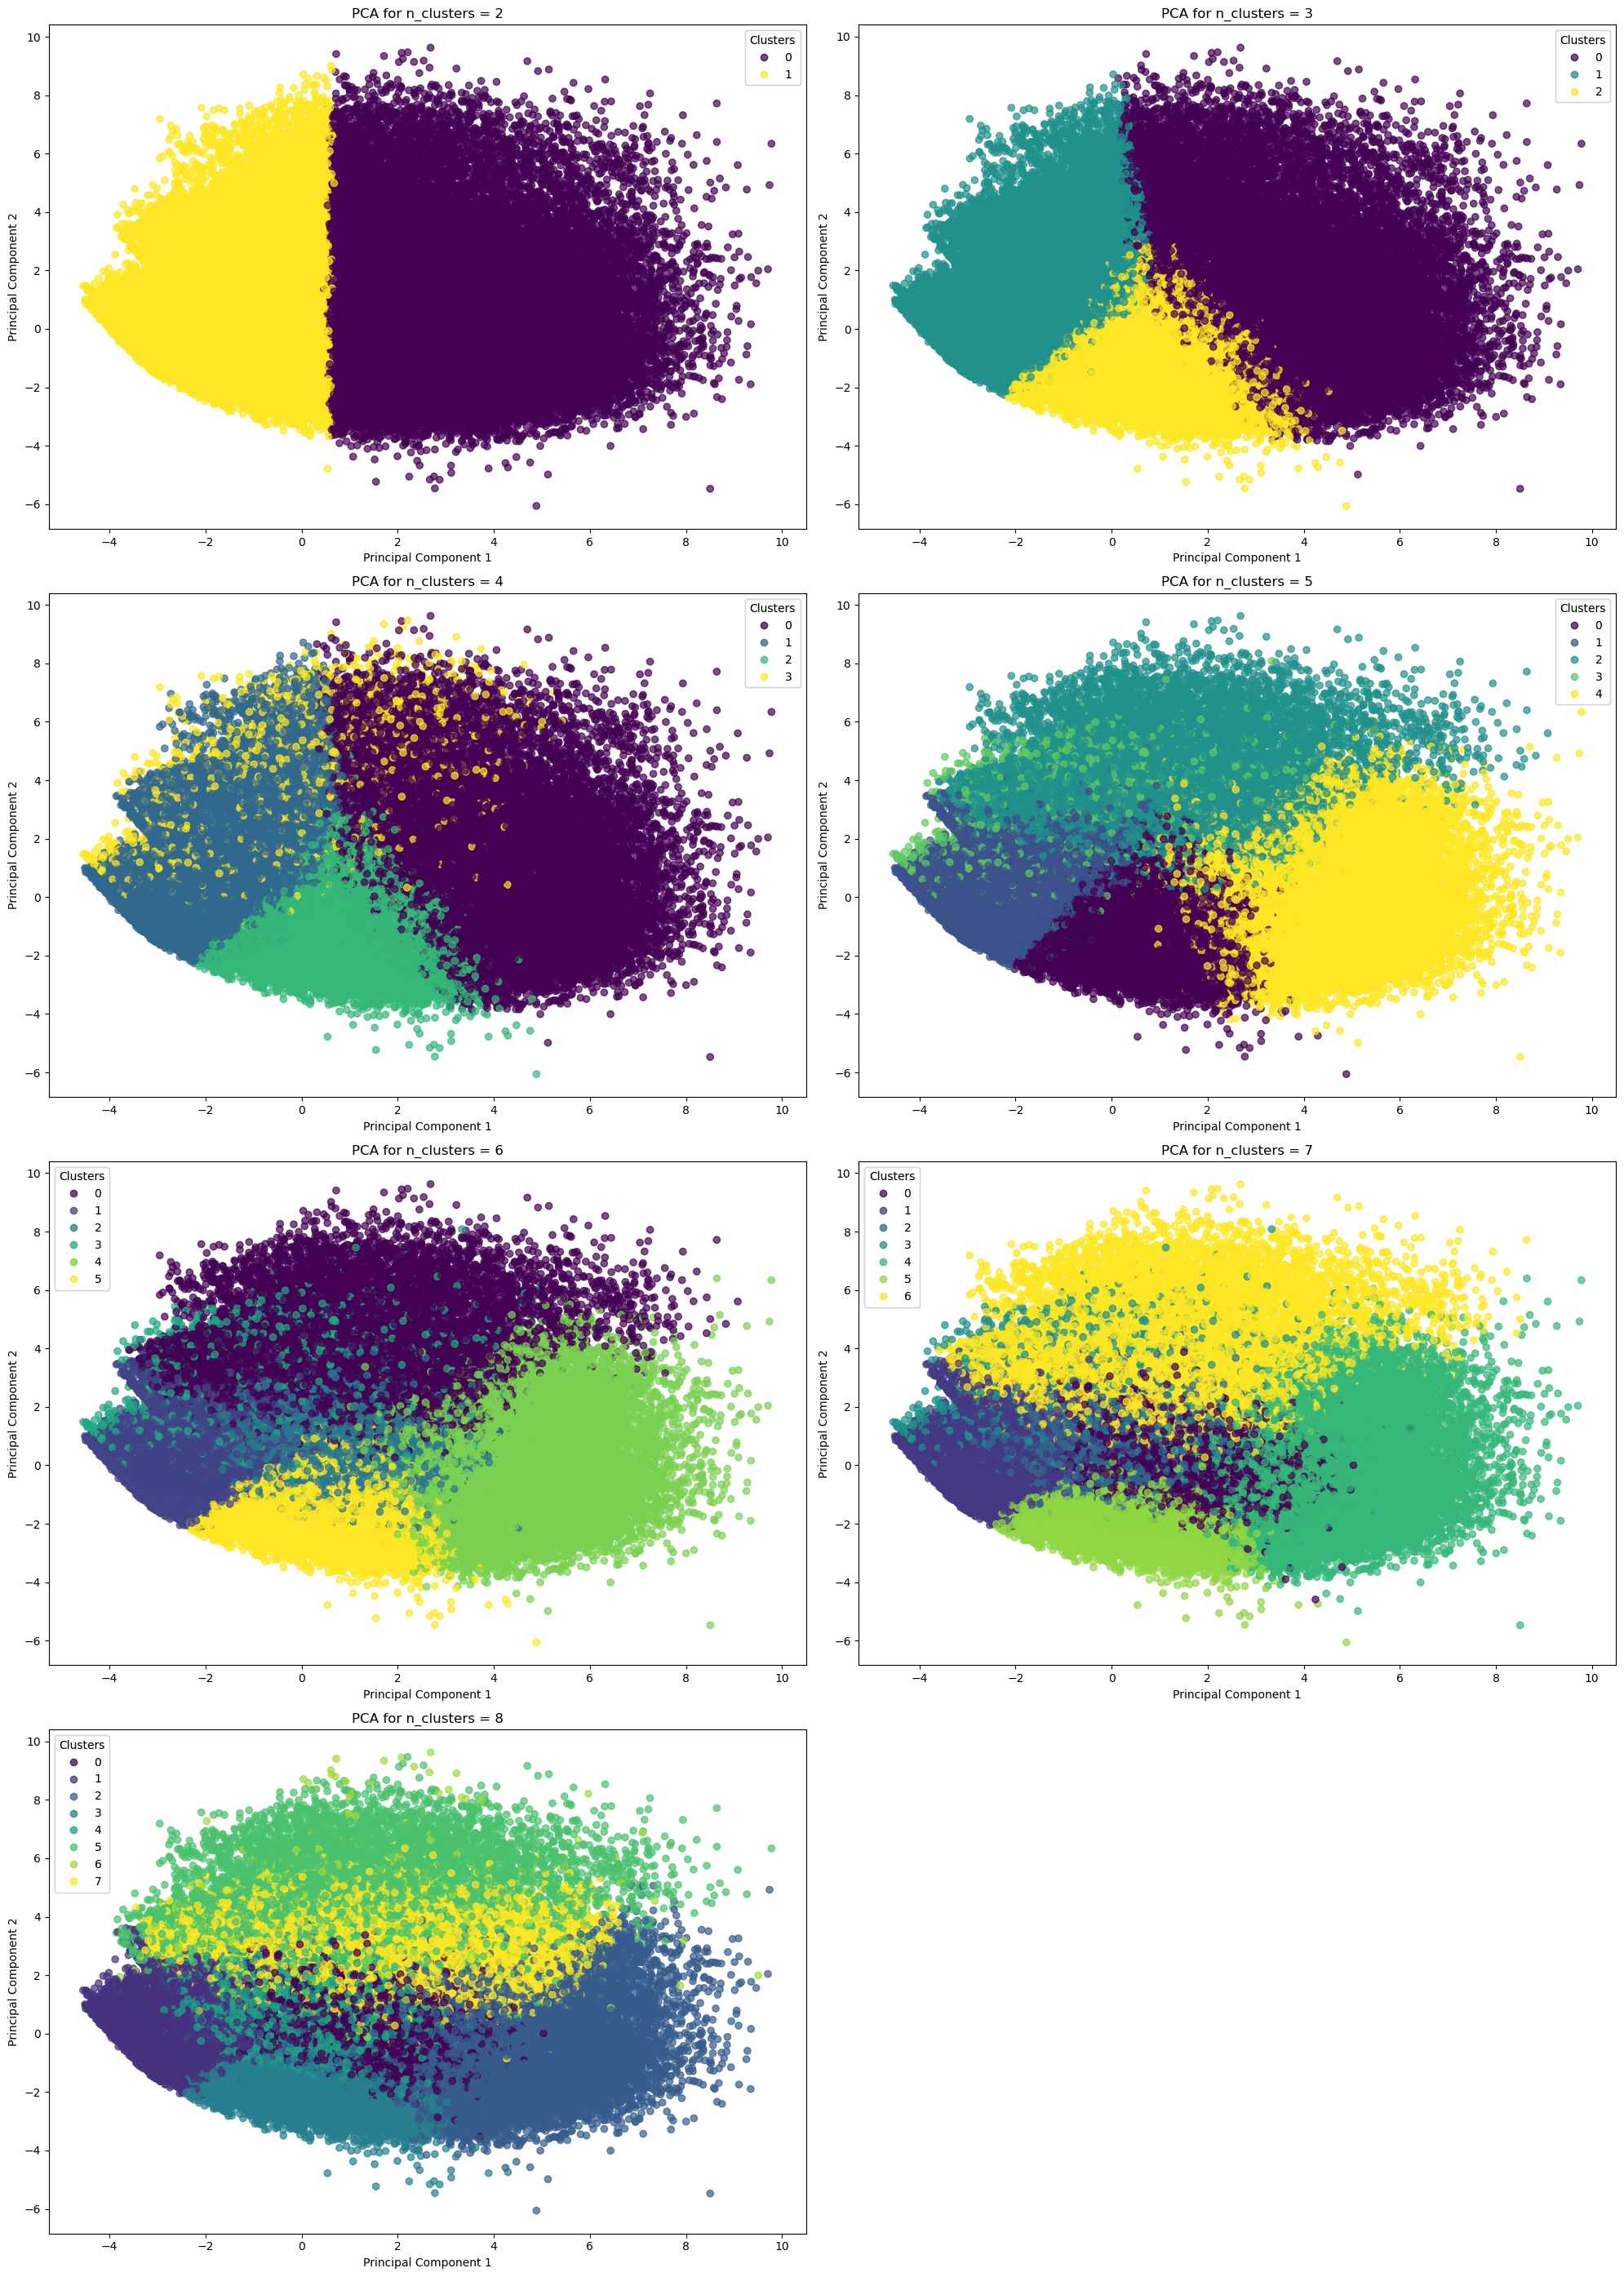

In [15]:

cluster_dict = cluster_training_data(X_new, y, cluster_list=[2, 3, 4, 5, 6, 7, 8], outcome_col='Diabetes')


cluster3_result = cluster_dict['clusters'][3]
cluster3_train_df = cluster3_result['train_df']      
cluster3_pipeline = cluster3_result['pipeline']    
cluster3_centroids = cluster3_result['centroids']     

clustering_test_df = cluster_dict['test_data']

In [27]:
X_train_class = cluster3_train_df.drop(columns=['Diabetes'])
y_train_class = cluster3_train_df['Diabetes']

X_test_unlabeled = clustering_test_df.drop(columns=['Diabetes'])

predicted_test_clusters = cluster3_pipeline.predict(X_test_unlabeled)
X_test_class = X_test_unlabeled.copy()
X_test_class['cluster'] = predicted_test_clusters

y_test_class = clustering_test_df['Diabetes']


# SVM with L2 penalty
pipeline_l2 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(penalty='l2', dual=True, random_state=42, class_weight='balanced', max_iter=20000))
])
pipeline_l2.fit(X_train_class, y_train_class)
pred_l2 = pipeline_l2.predict(X_test_class)
print("Classification Report for SVM with L2 Penalty:")
print(classification_report(y_test_class, pred_l2))

# SVM with L1 penalty (requires dual=False)
pipeline_l1 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(penalty='l1', dual=False, random_state=42, class_weight='balanced', max_iter=10000))
])
pipeline_l1.fit(X_train_class, y_train_class)
pred_l1 = pipeline_l1.predict(X_test_class)
print("Classification Report for SVM with L1 Penalty:")
print(classification_report(y_test_class, pred_l1))

c:\Users\angel\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report for SVM with L2 Penalty:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     43739
           1       0.31      0.79      0.44      6997

    accuracy                           0.73     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.87      0.73      0.77     50736

Classification Report for SVM with L1 Penalty:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     43739
           1       0.31      0.79      0.44      6997

    accuracy                           0.73     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.87      0.73      0.77     50736



# SVM with cluster labels as feature, 4 clusters

In [28]:

cluster4_result = cluster_dict['clusters'][4]
cluster4_train_df = cluster4_result['train_df']      # Training data with cluster labels.
cluster4_pipeline = cluster4_result['pipeline']      # Clustering pipeline trained on training data.
cluster4_centroids = cluster4_result['centroids']      # Centroids computed on training data.
# The held-out testing data (without cluster labels) is stored as:
clustering_test_df = cluster_dict['test_data']

In [29]:
X_train_class = cluster4_train_df.drop(columns=['Diabetes'])
y_train_class = cluster4_train_df['Diabetes']


X_test_unlabeled = clustering_test_df.drop(columns=['Diabetes'])


predicted_test_clusters = cluster4_pipeline.predict(X_test_unlabeled)
X_test_class = X_test_unlabeled.copy()
X_test_class['cluster'] = predicted_test_clusters

y_test_class = clustering_test_df['Diabetes']

# --- Train SVM Classifiers ---

# SVM with L2 penalty
pipeline_l2 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(penalty='l2', dual=True, random_state=42, class_weight='balanced', max_iter=20000))
])
pipeline_l2.fit(X_train_class, y_train_class)
pred_l2 = pipeline_l2.predict(X_test_class)
print("Classification Report for SVM with L2 Penalty:")
print(classification_report(y_test_class, pred_l2))

# SVM with L1 penalty (requires dual=False)
pipeline_l1 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(penalty='l1', dual=False, random_state=42, class_weight='balanced', max_iter=10000))
])
pipeline_l1.fit(X_train_class, y_train_class)
pred_l1 = pipeline_l1.predict(X_test_class)
print("Classification Report for SVM with L1 Penalty:")
print(classification_report(y_test_class, pred_l1))

c:\Users\angel\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report for SVM with L2 Penalty:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     43739
           1       0.31      0.79      0.44      6997

    accuracy                           0.73     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.87      0.73      0.77     50736

Classification Report for SVM with L1 Penalty:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     43739
           1       0.31      0.79      0.44      6997

    accuracy                           0.73     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.87      0.73      0.77     50736



# XGB Boost classifier

In [13]:

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)


xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')


param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1],           
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

# use the best estimator to predict and print a classification report
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

print("Classification Report for XGBoost Classifier:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best parameters found:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.8}
Classification Report for XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     43739
           1       0.57      0.16      0.25      6997

    accuracy                           0.87     50736
   macro avg       0.73      0.57      0.59     50736
weighted avg       0.84      0.87      0.83     50736



## Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Define a parameter grid (customize as desired)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Setup GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='accuracy',   # or another scoring metric
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit to training data
rf_grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found for RandomForestClassifier:")
print(rf_grid_search.best_params_)

# Use the best estimator to predict and print a classification report
best_rf = rf_grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Classification Report for RandomForestClassifier:")
print(classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Nida Firdaws\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters found for RandomForestClassifier:
{'bootstrap': True, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     43739
           1       0.60      0.06      0.12      6997

    accuracy                           0.87     50736
   macro avg       0.74      0.53      0.52     50736
weighted avg       0.83      0.87      0.82     50736



## Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Initialize the model
logreg_model = LogisticRegression(random_state=42)

# Define a parameter grid (customize as needed)
# Note: 'solver' and 'penalty' must be compatible. 'liblinear' supports 'l1' and 'l2'.
logreg_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1.0, 10.0],
    'solver': ['liblinear']
}

# Setup GridSearchCV
logreg_grid_search = GridSearchCV(
    estimator=logreg_model,
    param_grid=logreg_param_grid,
    scoring='accuracy',  # or another suitable metric
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit to training data
logreg_grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found for LogisticRegression:")
print(logreg_grid_search.best_params_)

# Use the best estimator to predict and print a classification report
best_logreg = logreg_grid_search.best_estimator_
y_pred_logreg = best_logreg.predict(X_test)

print("Classification Report for LogisticRegression:")
print(classification_report(y_test, y_pred_logreg))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Nida Firdaws\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters found for LogisticRegression:
{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     43739
           1       0.55      0.16      0.25      6997

    accuracy                           0.87     50736
   macro avg       0.72      0.57      0.59     50736
weighted avg       0.83      0.87      0.83     50736



## CatBoost

In [50]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Initialize the model
cat_model = CatBoostClassifier(
    random_state=42,
    verbose=False  # to suppress CatBoost's internal training output
)

# Define a parameter grid (tweak these values to suit your dataset and needs)
cat_param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.1, 0.01],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5]
}

cat_grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_param_grid,
    scoring='accuracy',  # or another metric you prefer
    cv=5,
    verbose=1,
    n_jobs=-1
)

cat_grid_search.fit(X_train, y_train)

print("Best parameters found for CatBoost:")
print(cat_grid_search.best_params_)

best_cat = cat_grid_search.best_estimator_
y_pred_cat = best_cat.predict(X_test)

print("Classification Report for CatBoost Classifier:")
print(classification_report(y_test, y_pred_cat))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\Nida Firdaws\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
3 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Nida Firdaws\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nida Firdaws\anaconda3\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\Nida Firdaws\anaconda3\Lib\site-packag

Best parameters found for CatBoost:
{'depth': 7, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Classification Report for CatBoost Classifier:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     43739
           1       0.58      0.16      0.25      6997

    accuracy                           0.87     50736
   macro avg       0.73      0.57      0.59     50736
weighted avg       0.84      0.87      0.83     50736



Our XGBoost model achieved about 87% accuracy in detecting diabetes, but it primarily excelled at identifying non-diabetic patients and struggled with actual diabetics. This highlights how the class imbalance inflates overall accuracy while recall for the minority class remains low.

Similarly, Random Forest posted high accuracy yet caught only a fraction of positive diabetes cases, reflecting the same imbalance issue. Even with fine-tuned parameters, it still focused heavily on the majority class.

Logistic Regression and CatBoost mirrored these trends, each reaching around 87% accuracy but providing weak recall for actual diabetics. This pattern suggests we need balancing techniques or different metrics to truly evaluate success in detecting diabetes.